In [1]:
from definitions import *

%load_ext autoreload
%autoreload 2

In [2]:
exp_wind = ClusteringExperiment('ERA5', 'Wind', '300', None, None, -60, 60, 20, 80, False, 'anomaly', 'JJA')
exp_T = ClusteringExperiment('ERA5', 'Temperature', '2m', 'box_-25_60_32_72', 't', None, None, None, None, False, 'anomaly', 'JJA')
da_wind = exp_wind.open_da('anomaly', 'JJA')
da_T = exp_T.open_da('anomaly', 'JJA')

exp_prec = Experiment(exp_wind.dataset, 'Precipitation', 'surf', 'box_-25_60_32_72', 'tp')
da_prec = exp_prec.open_da('anomaly', 'JJA')
da_prec = da_prec.drop_duplicates(dim='time').interp(time=da_wind.time)

In [3]:
X, da_wind = exp_wind.prepare_for_clustering()

X = exp_wind.pca_transform(X, 150)

# $T_1$ OPPs

In [4]:
eigenvals_T1, OPPs_T1, path_T1 = exp_wind.compute_opps(150, return_realspace=True, type=1)
raw_OPPs_T1 = load_pickle(path_T1)['OPPs']
OPP_timeseries_T1 = exp_wind.opp_transform(X, 150, 10, type=1)
mask_high_T1 = OPP_timeseries_T1 > 2
mask_low_T1 = OPP_timeseries_T1 < -2
mask_max_T1 = np.argmax(OPP_timeseries_T1, axis=1)[:, None] == np.arange(OPP_timeseries_T1.shape[1])[None, :]
mask_min_T1 = np.argmin(OPP_timeseries_T1, axis=1)[:, None] == np.arange(OPP_timeseries_T1.shape[1])[None, :]

OPP_timeseries_da_T1 = xr.DataArray(
    OPP_timeseries_T1, 
    coords={'time': da_wind.time, 'OPP': np.arange(OPP_timeseries_T1.shape[1])}
)
hotspells, maxnhs, maxlen = get_hostpells_v2()
OPP_mask_da_T1 = apply_hotspells_mask_v2(hotspells, OPP_timeseries_da_T1, maxlen, maxnhs)

# $T_2$ OPPs

In [5]:
eigenvals_T2, OPPs_T2, path_T2 = exp_wind.compute_opps(150, return_realspace=True, type=2)
raw_OPPs_T2 = load_pickle(path_T2)['OPPs']
OPP_timeseries_T2 = exp_wind.opp_transform(X, 150, 10, type=2)
mask_high_T2 = OPP_timeseries_T2 > 2
mask_low_T2 = OPP_timeseries_T2 < -2
mask_max_T2 = np.argmax(OPP_timeseries_T2, axis=1)[:, None] == np.arange(OPP_timeseries_T2.shape[1])[None, :]
mask_min_T2 = np.argmin(OPP_timeseries_T2, axis=1)[:, None] == np.arange(OPP_timeseries_T2.shape[1])[None, :]

OPP_timeseries_da_T2 = xr.DataArray(
    OPP_timeseries_T2, 
    coords={'time': da_wind.time, 'OPP': np.arange(OPP_timeseries_T2.shape[1])}
)
hotspells, maxnhs, maxlen = get_hostpells_v2()
OPP_mask_da_T2 = apply_hotspells_mask_v2(hotspells, OPP_timeseries_da_T2, maxlen, maxnhs)

In [6]:
eigenvals_T1

array([22.3274346 , 16.42323505, 14.16061486, 13.30688202, 10.50325454,
       10.3933041 ,  9.63965972,  8.8127245 ,  8.56069351,  8.0863367 ,
        7.93714536,  7.73568766,  7.36882678,  6.70456033,  6.58772076,
        5.84061527,  5.39226526,  5.33254618,  5.22915822,  4.75419164,
        4.67807264,  4.53620575,  4.28132316,  4.19438785,  4.17324433,
        4.01201335,  3.94507573,  3.59775576,  3.40531306,  3.36416314,
        3.099523  ,  2.89457778,  2.83460101,  2.66568235,  2.55343494,
        2.38354819,  2.26284165,  2.19019019,  2.15165701,  2.02411906,
        1.95921598,  1.86646228,  1.7748959 ,  1.71669483,  1.65348484,
        1.58685761,  1.47223836,  1.47398035,  1.42077968,  1.38218985,
        1.33023809,  1.29766888,  1.24978177,  1.21589061,  1.16390327,
        1.14158875,  1.14617865,  1.07335477,  1.01612536,  1.01158425,
        0.99250199,  0.96732049,  0.94417895,  0.90334253,  0.89735603,
        0.86311366,  0.87480555,  0.81516312,  0.82088073,  0.80

In [7]:
eigenvals_T2

array([13.28981899,  9.11345079,  8.02514743,  7.91375548,  7.20020501,
        6.30913409,  5.95022344,  5.19984199,  5.05792638,  4.34060059])

# $T_1$ vs. $T_2$

## Absolute

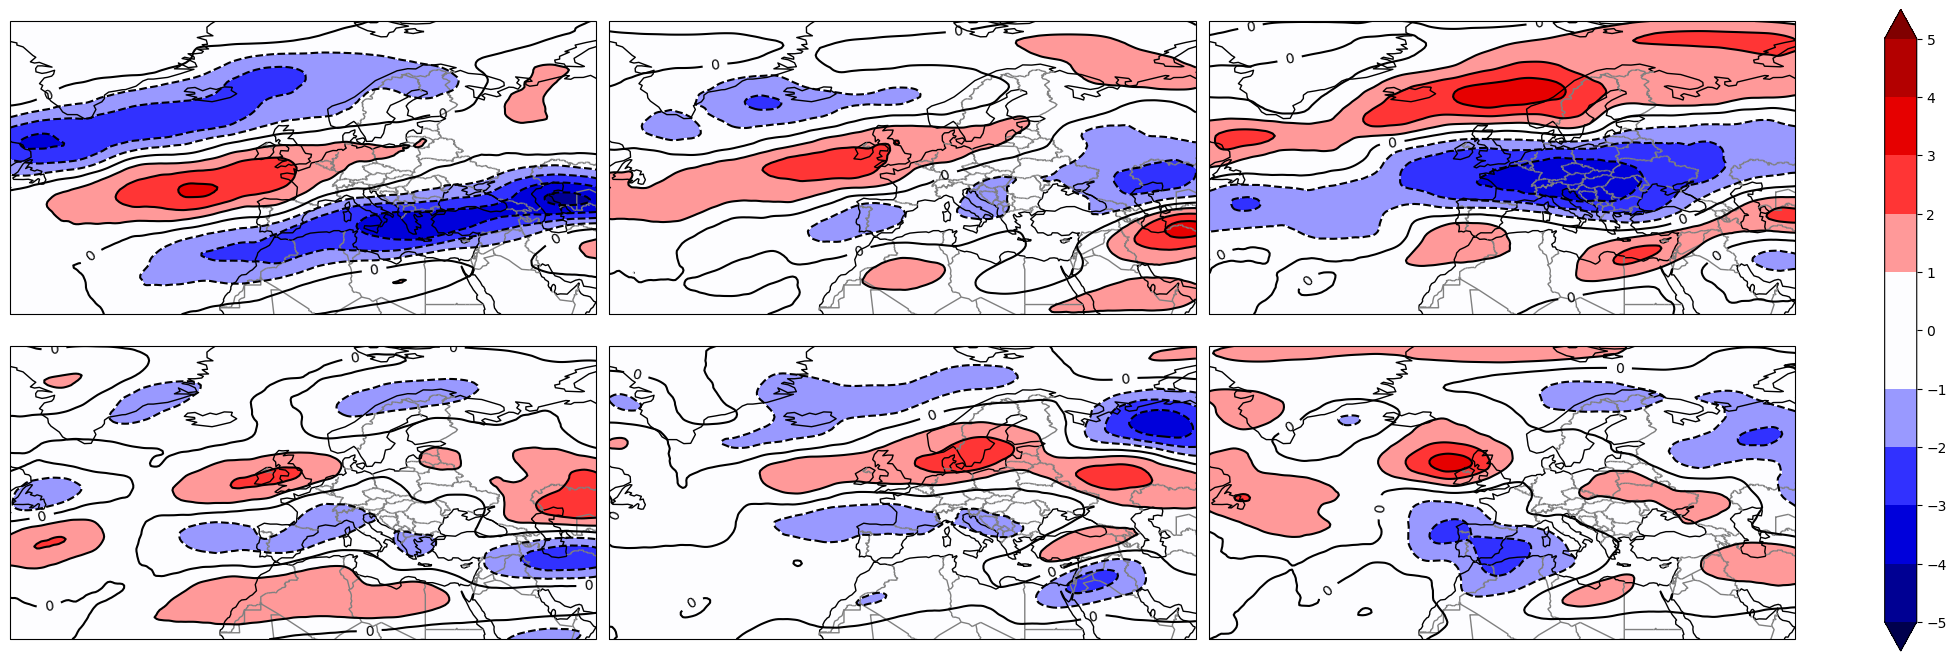

In [8]:
_ = clusterplot(2, 3, [OPPs_T1[i] for i in range(6)], 6, 5, clabels=[0])

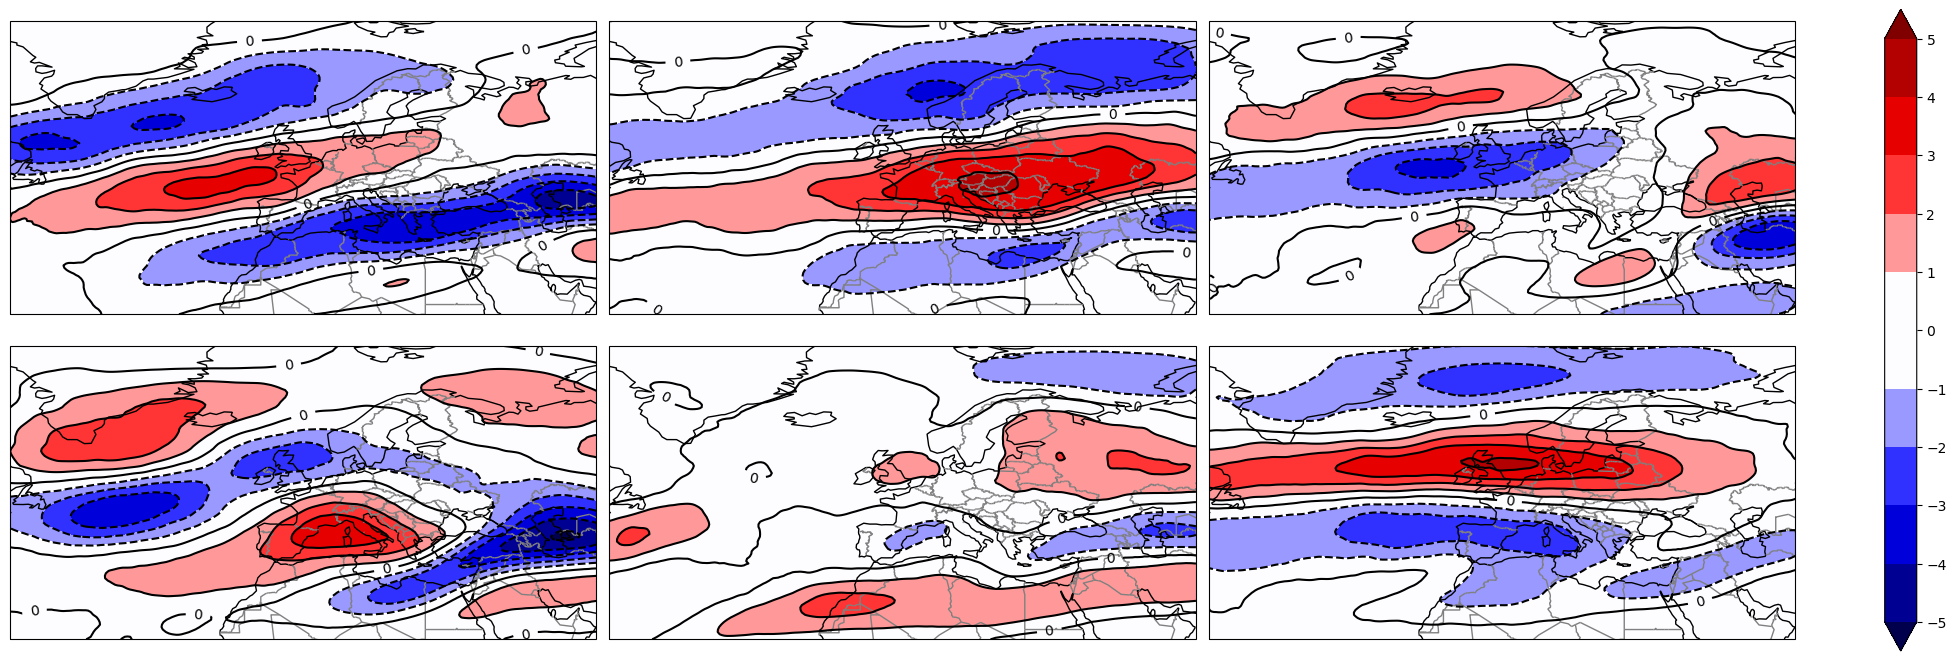

In [9]:
_ = clusterplot(2, 3, [OPPs_T2[i] for i in range(6)], 6, 5, clabels=[0])

## As means

(<Figure size 1950x650 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f8849d28310>)

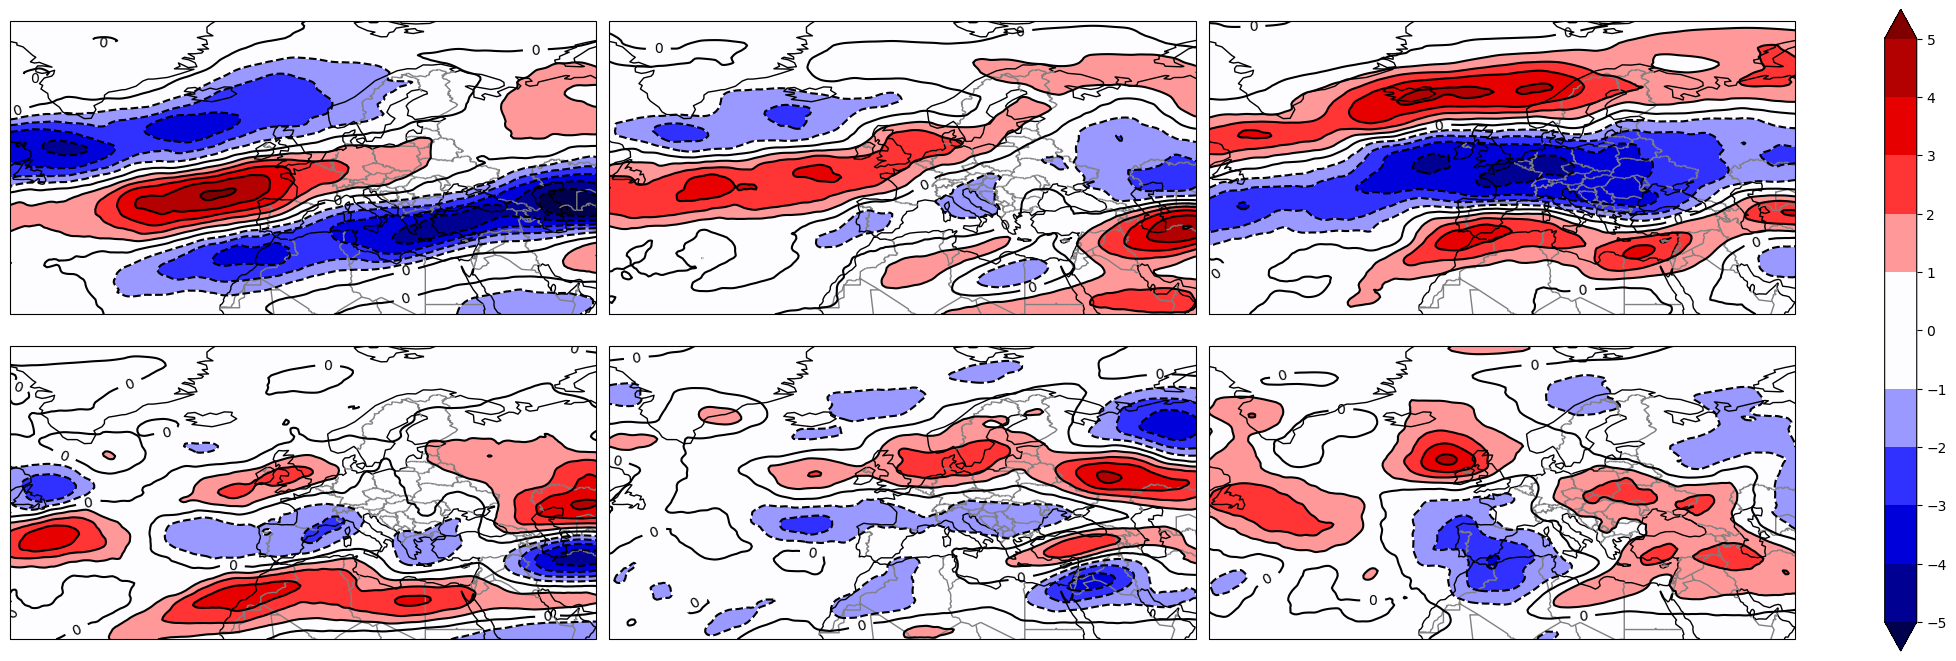

In [10]:
to_plot = [da_wind.isel(time=mask_max_T1[:, i]).mean(dim='time') for i in range(6)]
clusterplot(2, 3, to_plot, 6, 5, clabels=[0])

(<Figure size 1950x650 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f884bc06090>)

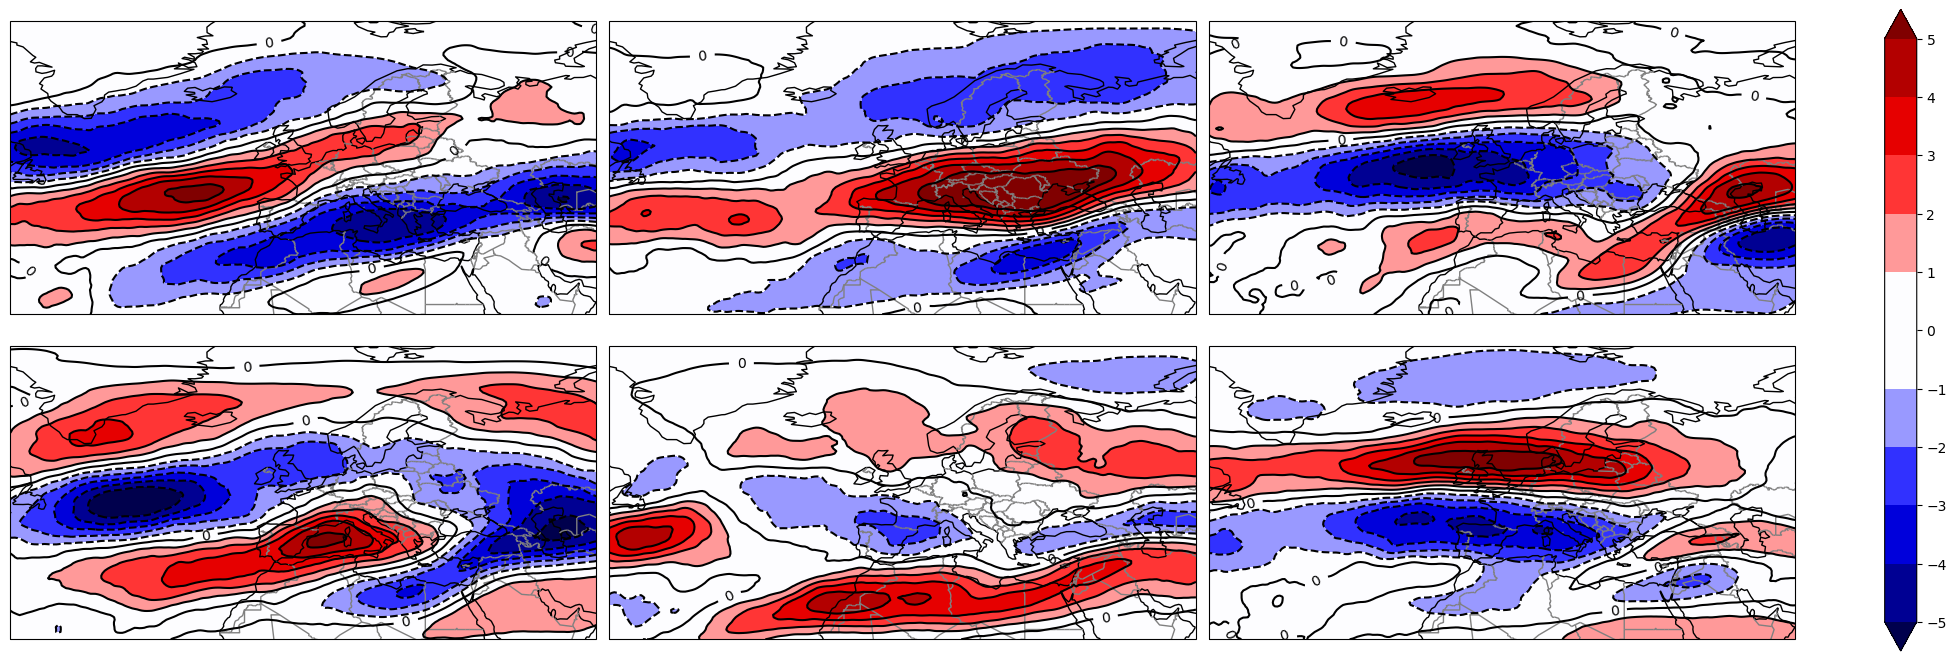

In [11]:
to_plot = [da_wind.isel(time=mask_max_T2[:, i]).mean(dim='time') for i in range(6)]
clusterplot(2, 3, to_plot, 6, 5, clabels=[0])

## OPPs vs. hotspells

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


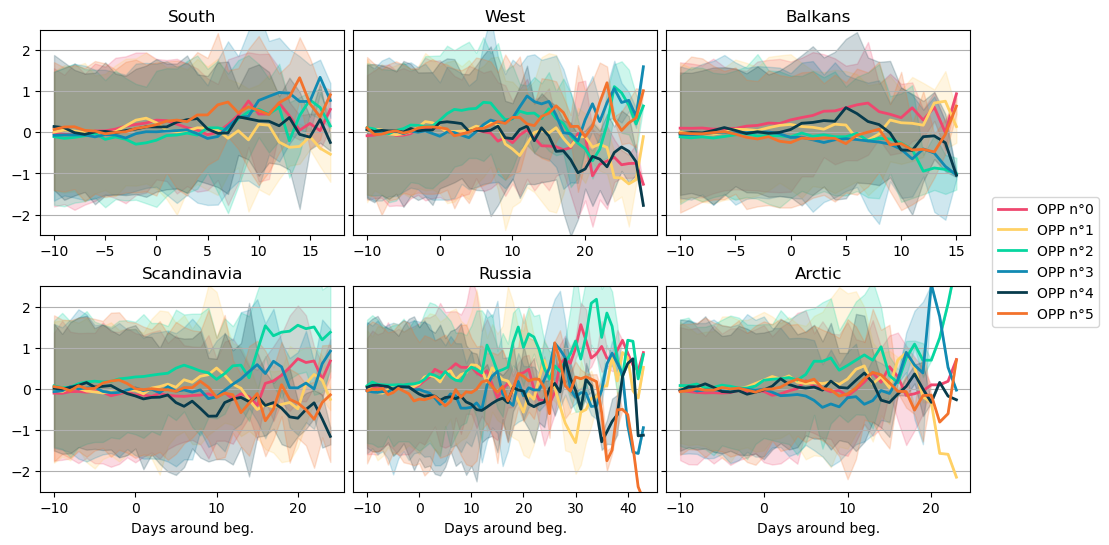

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=0.03, hspace=0.25)
axes = axes.flatten()
means = OPP_mask_da_T1.isel(OPP=np.arange(6)).mean(dim='hotspell')
quantiles = OPP_mask_da_T1.isel(OPP=np.arange(6)).quantile([0.05, 0.95], dim='hotspell')
for i, (ax, region) in enumerate(zip(axes, REGIONS)):
    for OPP, color in zip(range(6), COLORS5):
        this = means.sel(region=region).isel(OPP=OPP)
        maxidx = np.sum(~np.isnan(this.values))
        this = this[:maxidx]
        q1, q2 = quantiles.sel(region=region).isel(OPP=OPP)[:, :maxidx]
        ax.plot(this.day_after_beg, this, lw=2, color=color, label=f'OPP n°{OPP}')
        ax.fill_between(this.day_after_beg, q1, q2, color=color, alpha=0.2)
        ax.set_ylim([-2.5, 2.5])
        if i % 3 == 0:
            ax.set_yticks([-2, -1, 0, 1, 2])
        else:
            ax.set_yticks([-2, -1, 0, 1, 2], [''] * 5)
        if i > 2:
            ax.set_xlabel('Days around beg.')
        ax.grid(True, axis='y')
        ax.set_title(region)
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1.05, 1.12))

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


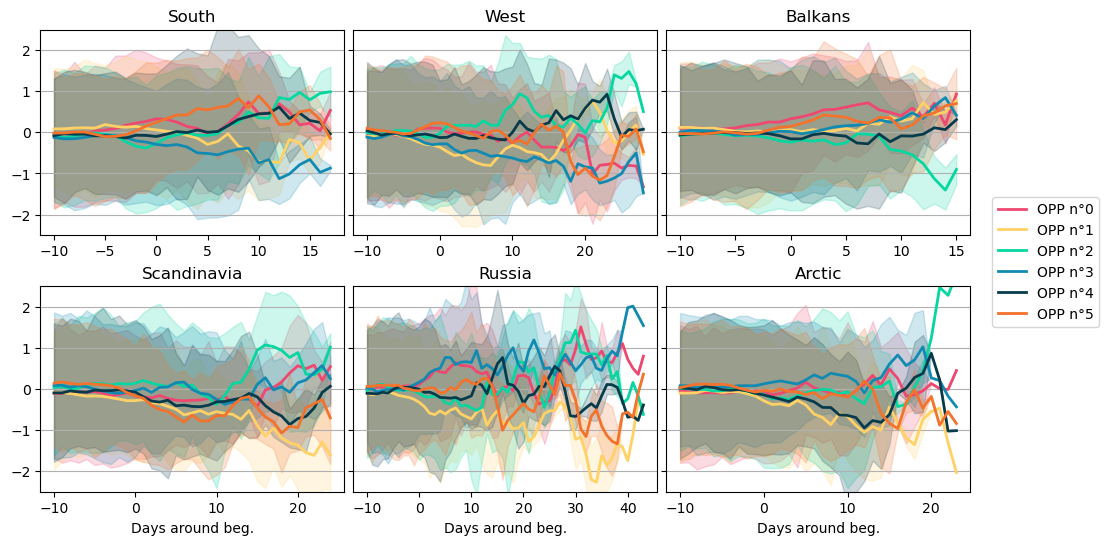

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=0.03, hspace=0.25)
axes = axes.flatten()
means = OPP_mask_da_T2.isel(OPP=np.arange(6)).mean(dim='hotspell')
quantiles = OPP_mask_da_T2.isel(OPP=np.arange(6)).quantile([0.05, 0.95], dim='hotspell')
for i, (ax, region) in enumerate(zip(axes, REGIONS)):
    for OPP, color in zip(range(6), COLORS5):
        this = means.sel(region=region).isel(OPP=OPP)
        maxidx = np.sum(~np.isnan(this.values))
        this = this[:maxidx]
        q1, q2 = quantiles.sel(region=region).isel(OPP=OPP)[:, :maxidx]
        ax.plot(this.day_after_beg, this, lw=2, color=color, label=f'OPP n°{OPP}')
        ax.fill_between(this.day_after_beg, q1, q2, color=color, alpha=0.2)
        ax.set_ylim([-2.5, 2.5])
        if i % 3 == 0:
            ax.set_yticks([-2, -1, 0, 1, 2])
        else:
            ax.set_yticks([-2, -1, 0, 1, 2], [''] * 5)
        if i > 2:
            ax.set_xlabel('Days around beg.')
        ax.grid(True, axis='y')
        ax.set_title(region)
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1.05, 1.12))

## OPPs versus T anomalies

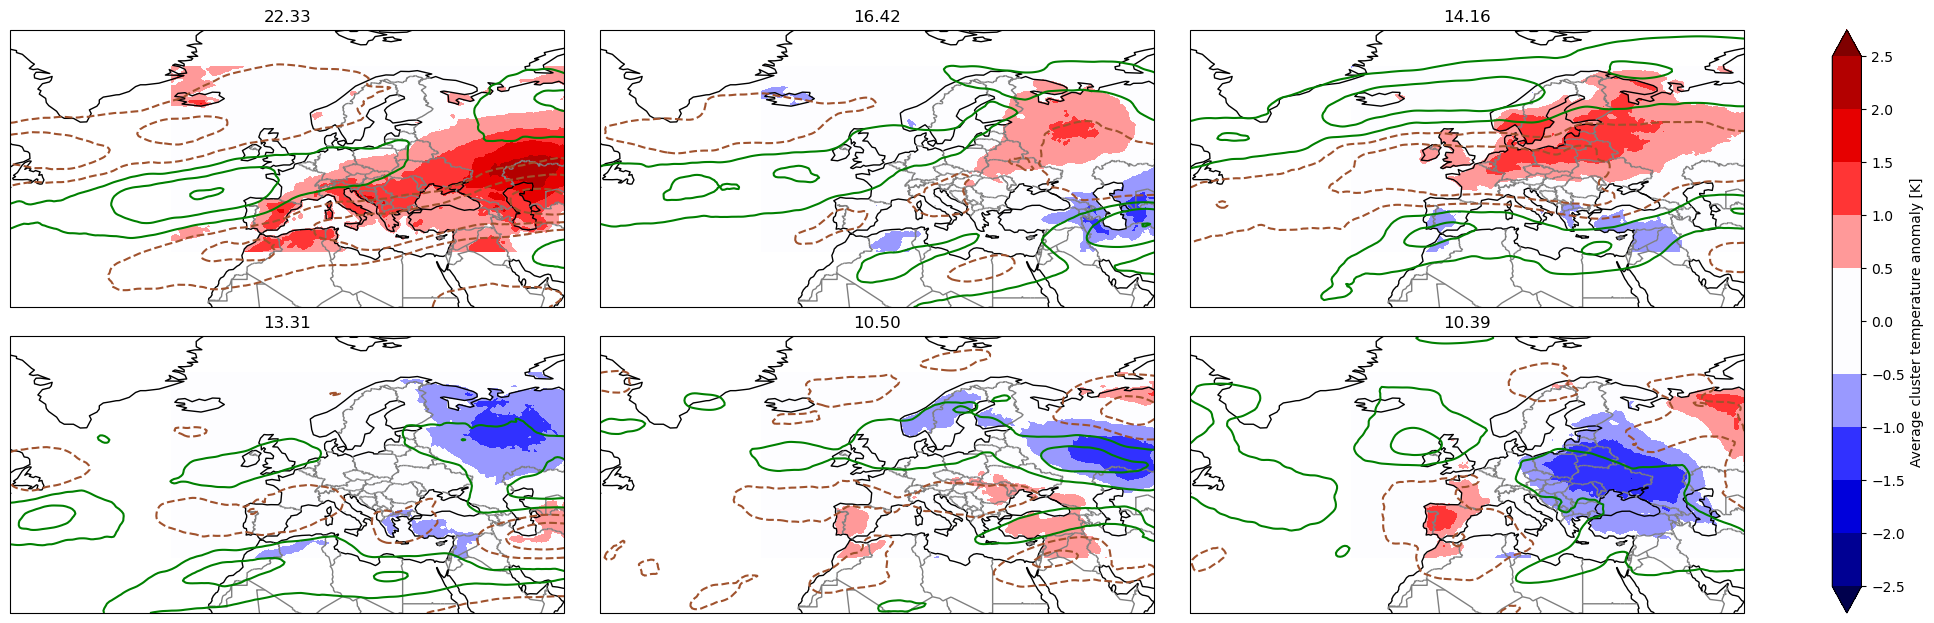

In [14]:
to_plot = [da_T.isel(time=mask_max_T1[:, i]).mean(dim='time') for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 6, 2.5, clabels=None, contours=False, cbar_ylabel='Average cluster temperature anomaly [K]')
to_plot = [da_wind.isel(time=mask_max_T1[:, i]).mean(dim='time') for i in range(6)]
levels = 6
levels2 = int(levels / 2)
colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt, eigenval in zip(axes, to_plot, eigenvals_T1):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-5, vmax=5, colors=colors, linestyles=linestyles)
    ax.set_title(f'{eigenval:.2f}')

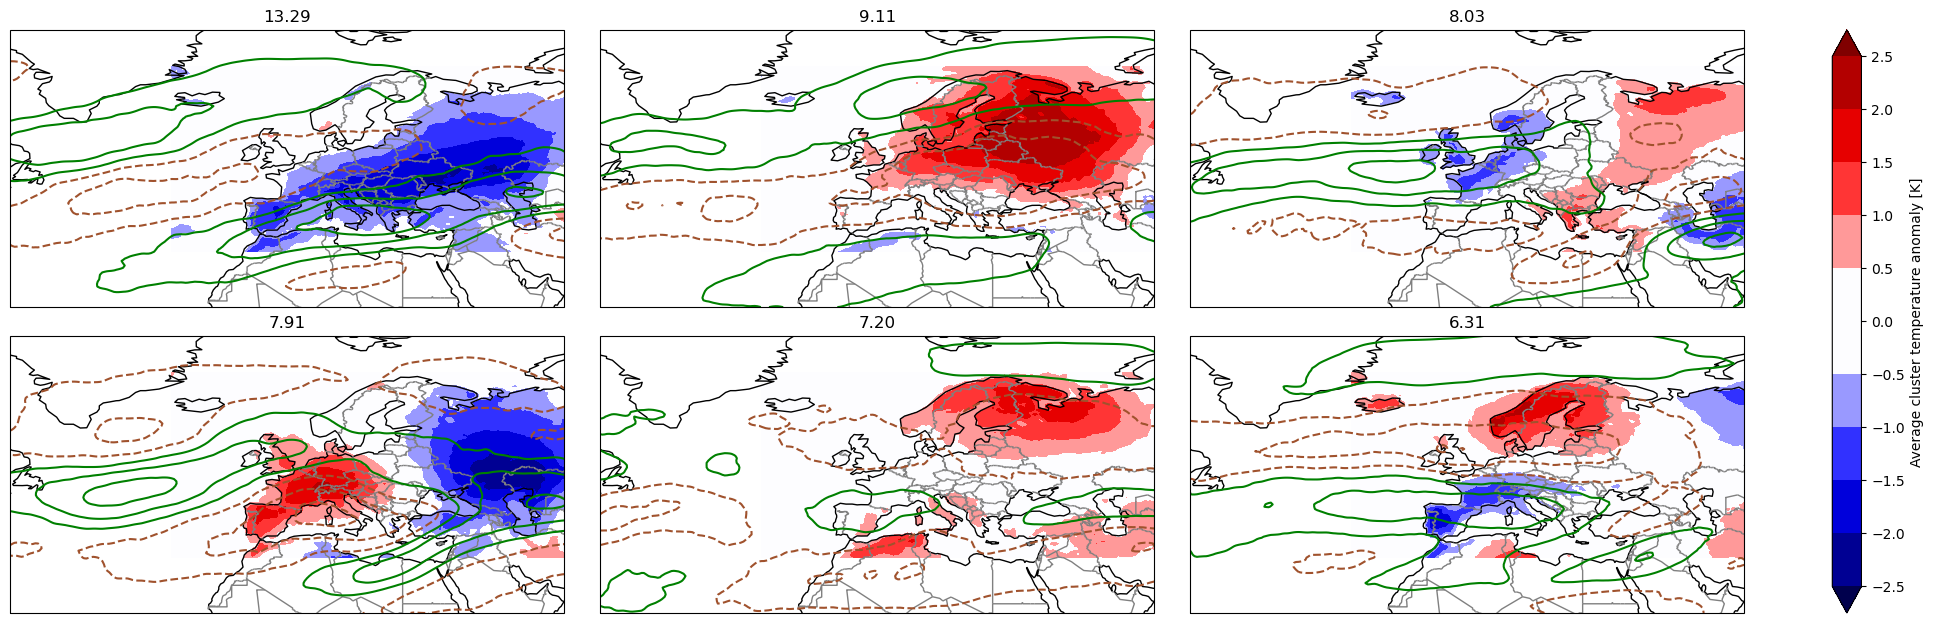

In [15]:
to_plot = [da_T.isel(time=mask_min_T2[:, i]).mean(dim='time') for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 6, 2.5, clabels=None, contours=False, cbar_ylabel='Average cluster temperature anomaly [K]')
to_plot = [da_wind.isel(time=mask_min_T2[:, i]).mean(dim='time') for i in range(6)]
levels = 6
levels2 = int(levels / 2)
colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt, eigenval in zip(axes, to_plot, eigenvals_T2):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-5, vmax=5, colors=colors, linestyles=linestyles)
    ax.set_title(f'{eigenval:.2f}')

# OPPs vs prec anomalies

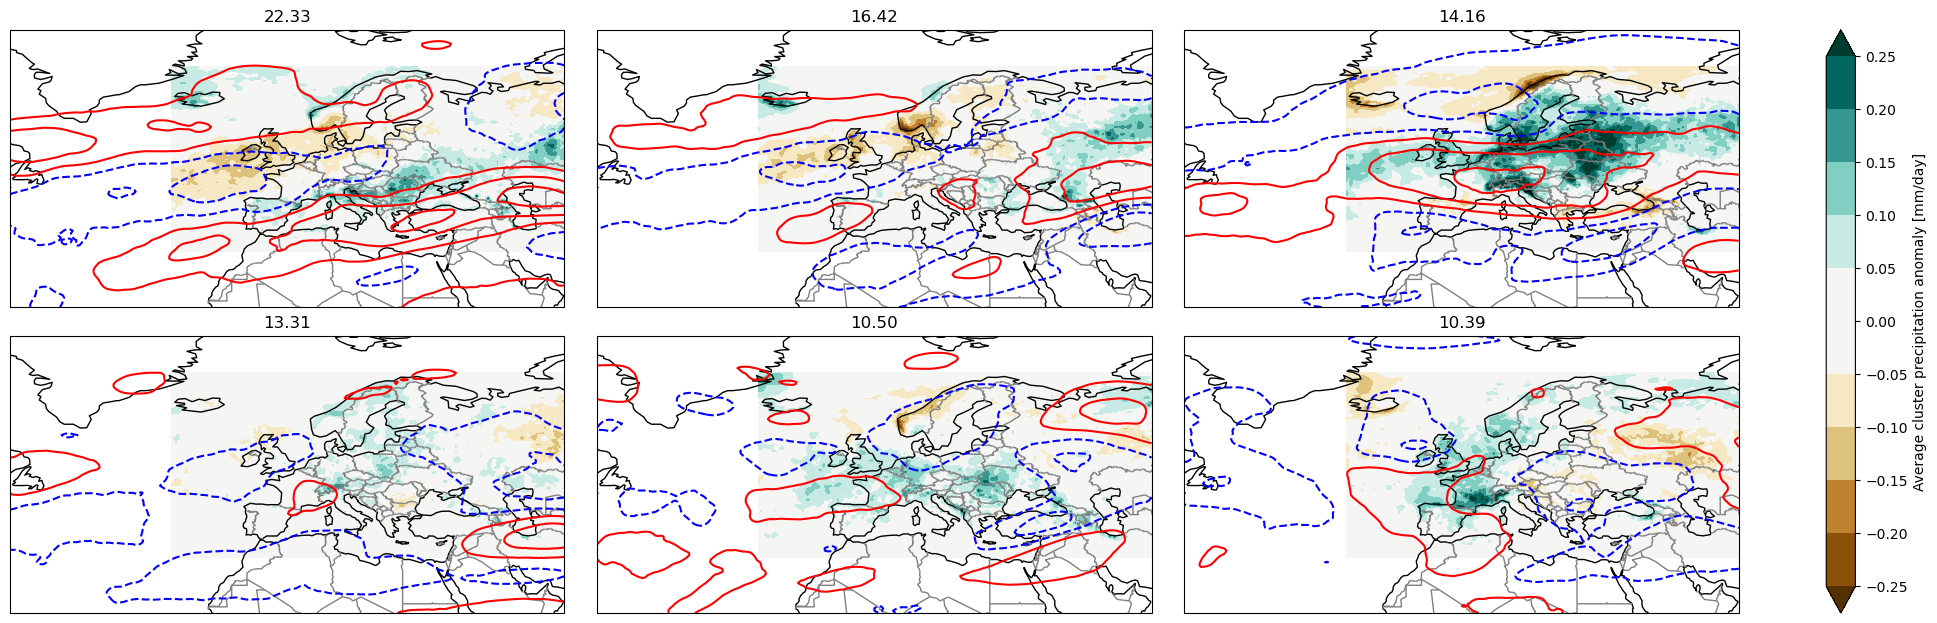

In [16]:
to_plot = [da_prec.isel(time=mask_min_T1[:, i]).mean(dim='time') / 1e-3 for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 6, .25, clabels=None, contours=False, cbar_ylabel='Average cluster precipitation anomaly [mm/day]', cmap='BrBG')
to_plot = [da_wind.isel(time=mask_min_T1[:, i]).mean(dim='time') for i in range(6)]
levels = 6
levels2 = int(levels / 2)
colors = levels2 * ['blue'] + (levels2 + 1) * ['red']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt, eigenval in zip(axes, to_plot, eigenvals_T1):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-5, vmax=5, colors=colors, linestyles=linestyles)
    ax.set_title(f'{eigenval:.2f}')

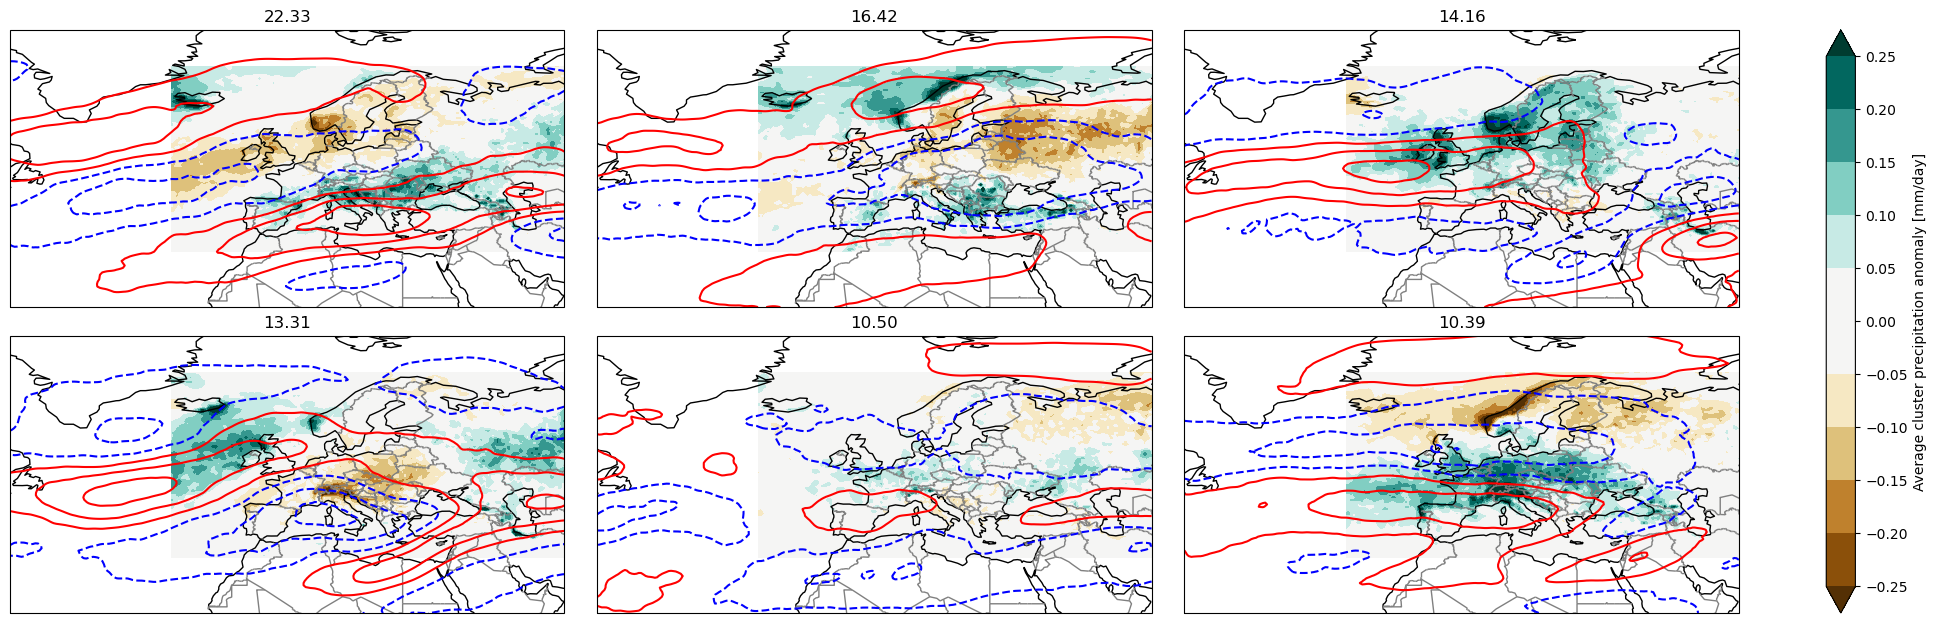

In [17]:
to_plot = [da_prec.isel(time=mask_min_T2[:, i]).mean(dim='time') / 1e-3 for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 6, .25, clabels=None, contours=False, cbar_ylabel='Average cluster precipitation anomaly [mm/day]', cmap='BrBG')
to_plot = [da_wind.isel(time=mask_min_T2[:, i]).mean(dim='time') for i in range(6)]
levels = 6
levels2 = int(levels / 2)
colors = levels2 * ['blue'] + (levels2 + 1) * ['red']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt, eigenval in zip(axes, to_plot, eigenvals_T1):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-5, vmax=5, colors=colors, linestyles=linestyles)
    ax.set_title(f'{eigenval:.2f}')

# Regionalized T anomalies

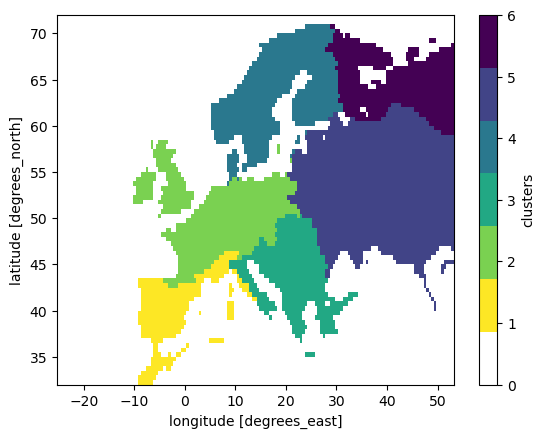

In [ ]:
duncan_mask = np.abs(xr.open_dataarray(f'{DATADIR}/ERA5/clusters_n6_eu_3w-def_correct-order.nc').fillna(0))
cmap = mpl.colormaps['viridis'].reversed()(np.linspace(0, 1, 6))
cmap = np.vstack([[1, 1, 1, 1], cmap])
cmap = ListedColormap(cmap)
duncan_mask.plot(cmap=cmap)

In [ ]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')
da_T = da_T.interp(lon=duncan_mask.lon, lat=duncan_mask.lat).assign_coords({'mask': duncan_mask})

In [ ]:
coords = {'time': da_T.time, 'region': REGIONS, 'quant': ['mean', 'median', 'min', 'max', 'q05', 'q95']}
timeseries = xr.DataArray(np.zeros([len(val) for val in coords.values()]), coords=coords)
for i, region in enumerate(REGIONS):
    base = da_T.where(da_T.mask==i + 1)
    timeseries.loc[:, region, 'mean'] = base.mean(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'median'] = base.median(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'min'] = base.min(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'max'] = base.max(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'q05'] = base.quantile(0.05, dim=['lon', 'lat'])
    timeseries.loc[:, region, 'q95'] = base.quantile(0.95, dim=['lon', 'lat'])
series2 = timeseries.values.reshape(-1, 36)
series1 = OPP_timeseries
corr = np.corrcoef(series1, series2, rowvar=False)
n_opp = OPP_timeseries.shape[1]
xcorr = corr[n_opp:, :n_opp]
xcorr = xr.DataArray(
    xcorr.reshape(6, 6, 180), 
    coords={
        'region': REGIONS, 'quant': ['mean', 'median', 'min', 'max', 'q05', 'q95'], 'OPP': np.arange(n_opp)},
)

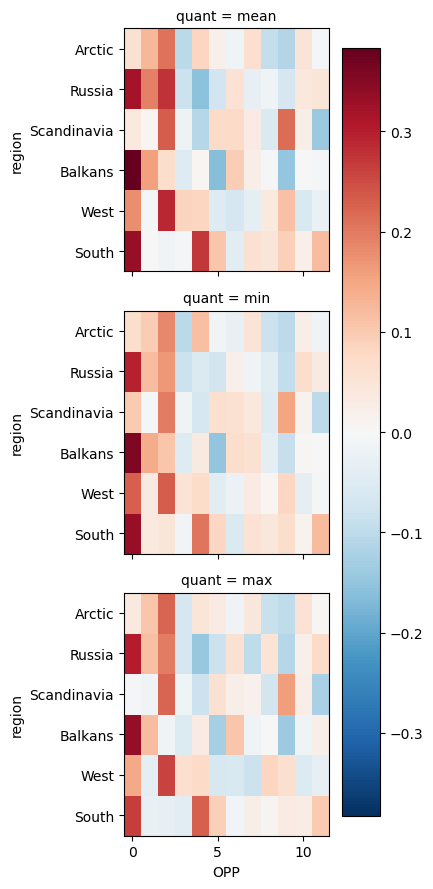

In [ ]:
xcorr.isel(OPP=np.arange(12), quant=[0, 2, 3]).plot.imshow(row='quant')

# DST

In [18]:
import CDSK as ck

In [19]:
ld, theta, alpha = ck.dynamical_local_indexes(X)
mu_ld, sigma_ld = np.mean(ld), np.std(ld)
mu_theta, sigma_theta = np.mean(theta), np.std(theta)

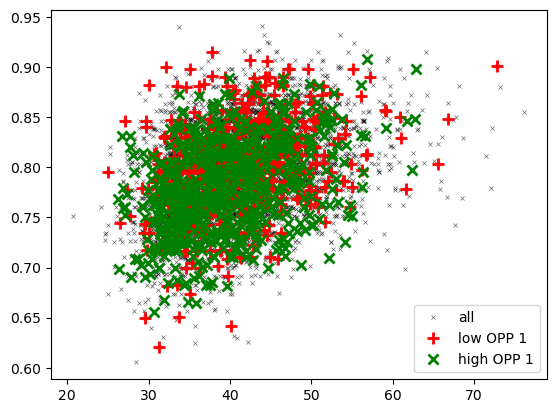

In [21]:
plt.plot(ld[:, 0, 0], theta[:, 0, 0], 'kx', mew=0.5, ms=3, alpha=0.6, label='all')
plt.plot(ld[mask_min_T1[:, 0], 0, 0], theta[mask_min_T1[:, 0], 0, 0], 'r+', mew=2, ms=9, label='low OPP 1')
plt.plot(ld[mask_max_T1[:, 0], 0, 0], theta[mask_max_T1[:, 0], 0, 0], 'gx', mew=2, ms=7, label='high OPP 1')
plt.legend()

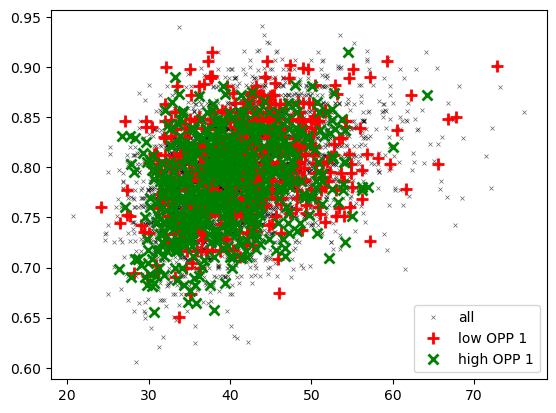

In [22]:
plt.plot(ld[:, 0, 0], theta[:, 0, 0], 'kx', mew=0.5, ms=3, alpha=0.6, label='all')
plt.plot(ld[mask_min_T2[:, 0], 0, 0], theta[mask_min_T2[:, 0], 0, 0], 'r+', mew=2, ms=9, label='low OPP 1')
plt.plot(ld[mask_max_T2[:, 0], 0, 0], theta[mask_max_T2[:, 0], 0, 0], 'gx', mew=2, ms=7, label='high OPP 1')
plt.legend()

In [84]:
ds_dsi = xr.Dataset(coords={'time': da_wind.time.values})
ds_dsi['ld'] = ('time', ld.flatten())
ds_dsi['theta'] = ('time', theta.flatten())

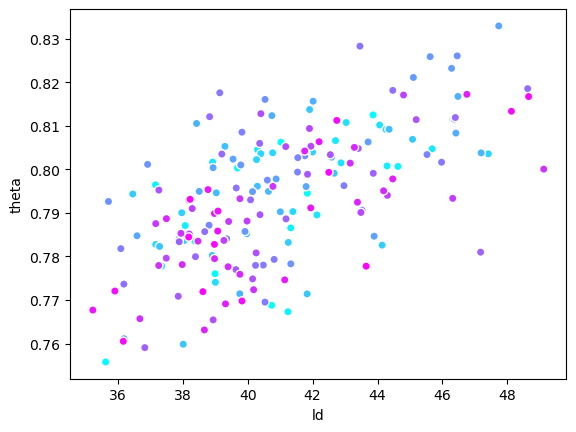

In [85]:
ds_dsi.resample(time='1M').mean(dim='time').plot.scatter(x='ld', y='theta', hue='time', cmap='cool', add_colorbar=False, add_legend=False)

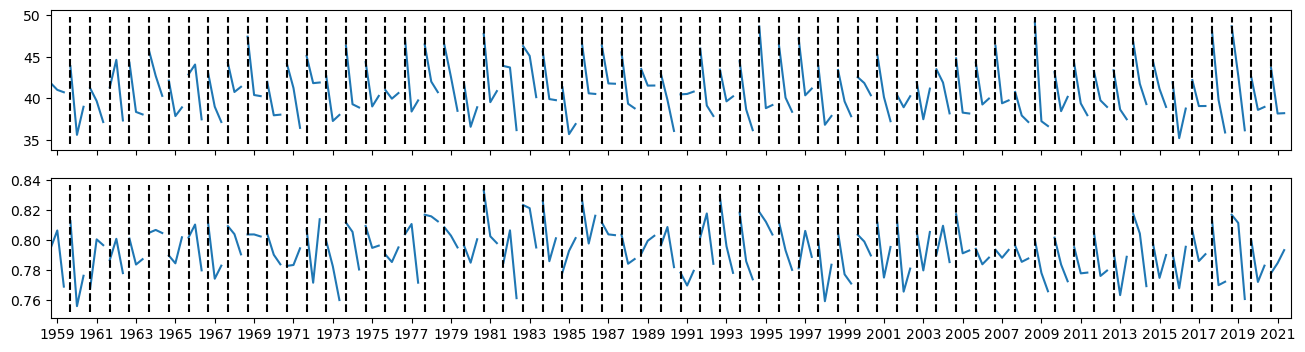

In [106]:
base = ds_dsi.resample(time='1M').mean(dim='time')
base = base.isel(time=np.isin(base.time.dt.month, [6, 7, 8]))
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16, 4))
lensummer = np.sum((base.time.dt.year == 1959).values)
years = np.unique(base.time.dt.year.values)
numsummer = len(years)
indices = np.arange(len(base.time)).reshape((numsummer, lensummer))
for idxs in indices:
    axes[0].plot(idxs, base['ld'][idxs].values, color='tab:blue')
    axes[1].plot(idxs, base['theta'][idxs].values, color='tab:blue')
axes[0].set_xlim([0, len(base.time)])
axes[0].set_xticks(np.arange(int(lensummer / 2), len(base.time), 2 * lensummer), years[::2])
for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(np.arange(lensummer, len(base.time), lensummer), ylims[0], ylims[1], color='black', ls='dashed')